In [14]:
%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'
try:
    import os
    rc('text.latex',preamble=r'\usepackage{%s/apjfonts}' %(str(os.getcwd())))
except:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import argparse, sys, numpy as np, scipy as sc, warnings, os
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/tools/')
#or look into https://github.com/sriniraghunathan/tools
import flatsky, tools, misc
import ilc, foregrounds as fg

#import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

In [16]:
#some constants
h=6.62607004e-34 #Planck constant in m2 kg / s
k_B=1.38064852e-23 #Boltzmann constant in m2 kg s-2 / K-1
Tcmb = 2.73 #Kelvin

In [17]:
#params
paramfile = 'params.ini'
freqarr = [90, 150, 220, 270]
beamarr= [2.3, 1.5, 1.0, 0.8]
noisearr_T = [2.0, 2.0, 6.9, 16.7]
elkneearr_T = [2154., 4364., 7334., 7308.]
alphakneearr_T = [3.5, 3.5, 3.5, 3.5]

noisearr_P = [2.9, 2.8, 9.8, 23.6]
elkneearr_P = [700., 700., 700., 700.]
alphakneearr_P = [1.4, 1.4, 1.4, 1.4]
'''
freqarr = [90, 150, 220]#, 270]
beamarr= [3.5,2.0,1.4]#, 0.8]
noisearr = [1.0, 1.0, 1.0]
elkneearr = [-1, -1, -1, -1]
alphakneearr = [0, 0, 0, 0]
'''

freqcalib_fac = None
final_comp = 'CMB'
TParr = ['T', 'P']

In [18]:
# read and store param dict
param_dict = misc.fn_get_param_dict(paramfile)
el = np.arange(param_dict['lmax'])

In [19]:
#collect beam and noise into a dic; elknee and alpha into a dic
beam_noise_dic = {}
elknee_dic = {}
for TP in TParr:
    beam_noise_dic[TP] = {}
    elknee_dic[TP] = {} 
    if TP == 'T':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_T, elkneearr_T, alphakneearr_T
    elif TP == 'P':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_P, elkneearr_P, alphakneearr_P

    for (freq, beam, noise, elknee, alphaknee) in zip(freqarr, beamarr, noisearr, elkneearr, alphakneearr):
        beam_noise_dic[TP][freq] = [beam, noise]
        elknee_dic[TP][freq] = [elknee, alphaknee]

In [20]:
#get beam deconvolved noise nls
nl_dic = {}
for TP in TParr:
    nl_dic[TP]={}
    for freq in freqarr:
        beamval, noiseval = beam_noise_dic[TP][freq]
        elknee, alphaknee = elknee_dic[TP][freq]

        nl = misc.get_nl(noiseval, el, beamval, elknee = elknee, alphaknee = alphaknee)
        nl[el<=param_dict['lmin']] = 0.
        nl[nl == 0.] = np.min(nl[nl!=0.])/1e3
        nl_dic[TP][freq] = nl

In [21]:
#get the CMB, noise, and foreground covriance
try:
    ignore_fg = param_dict['ignore_fg']
except:
    ignore_fg = []

ignore_fg.append(final_comp) #the required component need not go into the covariance matrix.

cl_dic = {}
for TP in TParr:
    if TP == 'T':
        el, cl_dic[TP] = ilc.get_covariance_dic(param_dict, freqarr, nl_dic = nl_dic['T'], ignore_fg = ignore_fg)
    elif TP == 'P':
        el, cl_dic[TP] = ilc.get_covariance_dic\
                    (param_dict, freqarr, nl_dic = nl_dic['P'], ignore_fg = ignore_fg, pol = 1, \
                    pol_frac_per_cent_dust = param_dict['pol_frac_per_cent_dust'], \
                    pol_frac_per_cent_radio = param_dict['pol_frac_per_cent_radio'], \
                    pol_frac_per_cent_tsz = param_dict['pol_frac_per_cent_tsz'], \
                    pol_frac_per_cent_ksz = param_dict['pol_frac_per_cent_ksz'], \
                    )
print(cl_dic.keys())

dict_keys(['T', 'P'])


In [22]:
#get the residual power now
cl_residual = {}
for TP in TParr:
    cl_residual[TP] = ilc.residual_power(param_dict, freqarr, el, cl_dic[TP], final_comp = final_comp, freqcalib_fac = freqcalib_fac)

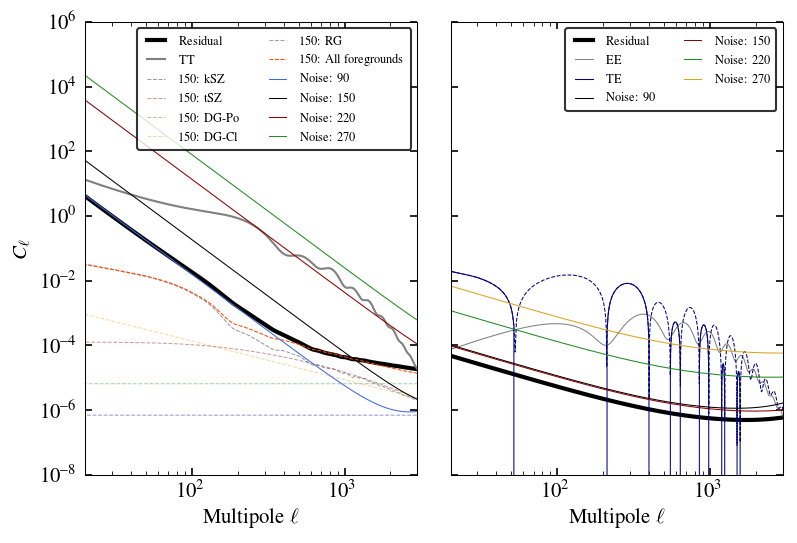

In [24]:
freq0, lmax = param_dict['freq0'], param_dict['lmax']
foregrounds_to_plot = ['kSZ', 'tSZ', 'DG-Po', 'DG-Cl', 'RG']


#CAMB output for plotting
camb_file = param_dict['Dlfile_len']
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])

cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T


clf(); 
subplots_adjust(wspace=0.1)
for cntr, TP in enumerate( TParr ):
    ax = subplot(1,2,cntr+1, xscale = 'log', yscale = 'log')
    plot(el, cl_residual[TP], 'black', lw = 2., label = r'Residual')
    if TP == 'T':
        plot(el_camb, cl_TT, 'gray', lw = 1., label = r'TT')
        cl_fg = np.zeros(len(el))
        for curr_fg in foregrounds_to_plot:
            el_, cl_curr_fg = fg.get_foreground_power_george_2015(curr_fg, freq1 = freq0, lmax = lmax)
            plot(el, cl_curr_fg, lw = 0.5, ls = '--', label = r'150: %s' %(curr_fg), alpha = 0.4)
            cl_fg += cl_curr_fg
        plot(el, cl_fg, lw = 0.5, ls = '--', label = r'150: All foregrounds', alpha = 1.)
    elif TP == 'P':
        plot(el_camb, cl_EE, 'gray', lw = 0.5, label = r'EE')
        plot(el_camb, cl_TE, 'navy', ls = '-', lw = 0.5, label = r'TE')        
        plot(el_camb, abs( cl_TE ), 'navy', ls = '--', lw = 0.5) 
    for freq in freqarr:
        plot(el, nl_dic[TP][freq], lw = 0.5, ls = '-', label = r'Noise: %s' %(freq))#, alpha = 0.5)
    legend(loc=1, fancybox=1, ncol = 2, fontsize = 6);
    xlim(20,lmax);ylim(1e-8,1e6);
    xlabel(r'Multipole $\ell$')
    if cntr == 0: 
        ylabel(r'$C_{\ell}$')
    else:
        setp(ax.get_yticklabels(which = 'both'), visible=False)
show()